In [74]:
import argparse
import datetime
import functools
import os
import subprocess
import sys

import numpy as np
import pandas as pd

import deTiN_utilities as du

import deTiN_SSNV_based_estimate as dssnv
import deTiN_aSCNA_based_estimate as dascna

class deTiN_input:
    """class which holds the required detin somatic data prior to model"""
    def __init__(self,args):

        # related to inputs from command line
        self.call_stats_file = args.mutation_data_path
        self.seg_file = args.cn_data_path
        self.tumor_het_file = args.tumor_het_data_path
        self.normal_het_file = args.normal_het_data_path
        self.exac_db_file = args.exac_data_path
        self.mutation_prior = args.mutation_prior
        self.TiN_prior = args.TiN_prior

        # related to inputs from class functions
        self.call_stats_table = []
        self.seg_table = []
        self.het_table = []
        self.candidates = []

    def read_call_stats_file(self):
        self.call_stats_table = pd.read_csv(self.call_stats_file, '\t', index_col=False, low_memory=False)
        if type(self.call_stats_table['contig'][0]) == str:
            self.call_stats_table['Chromosome'] = du.chr2num(np.array(self.call_stats_table['contig']))
        else:
            self.call_stats_table['Chromosome'] = np.array(self.call_stats_table['contig'])
        self.call_stats_table = self.call_stats_table[np.isfinite(self.call_stats_table['Chromosome'])]
        self.call_stats_table['genomic_coord_x'] = du.hg19_to_linear_positions(
            np.array(self.call_stats_table['Chromosome']), np.array(self.call_stats_table['position']))
        self.n_calls_in = len(self.call_stats_table)
    def read_het_file(self):
        tumor_het_table = pd.read_csv(self.tumor_het_file,'\t', index_col=False,low_memory=False)
        normal_het_table = pd.read_csv(self.normal_het_file,'\t',index_col=False,low_memory=False)

    def read_seg_file(self):
        self.seg_table = pd.read_csv(self.seg_file, '\t', index_col=False, low_memory=False)
        if not du.is_number(self.seg_table['Chromosome'][0]):
            self.seg_table['Chromosome'] = du.chr2num(np.array(self.seg_table['Chromosome']))
        else:
            self.seg_table['Chromosome'] = self.seg_table['Chromosome'] - 1
        self.seg_table['genomic_coord_start'] = du.hg19_to_linear_positions(np.array(self.seg_table['Chromosome']),
                                                                            np.array(self.seg_table['Start.bp']))
        self.seg_table['genomic_coord_end'] = du.hg19_to_linear_positions(np.array(self.seg_table['Chromosome']),
                                                                          np.array(self.seg_table['End.bp']))

    def annotate_call_stats_with_allelic_cn_data(self):
        f_acs = np.zeros([self.n_calls_in, 1]) + 0.5
        tau = np.zeros([self.n_calls_in, 1]) + 2
        for i, r in self.seg_table.iterrows():
            f_acs[np.logical_and(np.array(self.call_stats_table['genomic_coord_x']) >= r['genomic_coord_start'],
                               np.array(self.call_stats_table['genomic_coord_x']) <= r['genomic_coord_end'])] = r.f
            tau[np.logical_and(np.array(self.call_stats_table['genomic_coord_x']) >= r['genomic_coord_start'],
                               np.array(self.call_stats_table['genomic_coord_x']) <= r['genomic_coord_end'])] = r.tau + 0.001
        self.call_stats_table['tau'] = tau
        self.call_stats_table['f_acs'] = f_acs

    def read_and_preprocess_data(self):
        self.read_call_stats_file()
        self.read_seg_file()
        self.annotate_call_stats_with_allelic_cn_data()

class deTiN_output:
    """class which holds output from deTiN's models"""
__version__ = '1.0'

def main():
    """ Main execution engine of deTiN. Method operates in two stages (1) estimating tumor in normal via candidate SSNVs and SCNAS.
        (2) Performing variant re-classification using bayes rule.
        :rtype: deTIN_output"""

    parser = argparse.ArgumentParser(description='Estimate tumor in normal (TiN) using putative somatic'
                                                 ' events see Taylor-Weiner & Stewart et al. 2017')
    parser.add_argument('--mutation_data_path',
                        help='Path to mutation data.'
                             'Supported formats: MuTect call-stats, Strelka VCF', required=True)
    parser.add_argument('--cn_data_path',
                        help='Path to copy number data.'
                             'Supported format: GATK4CNV .seg file or AllelicCapseg .seg file', required=True)
    parser.add_argument('--tumor_het_data_path',
                        help='Path to heterozygous site allele count data in tumor.'
                             'Required columns: CONTIG,POS,REF_COUNT and ALT_COUNT', required=True)
    parser.add_argument('--normal_het_data_path',
                        help='Path to heterozygous site allele count data in normal.'
                             'Required columns: CONTIG,POS,REF_COUNT and ALT_COUNT', required=True)
    parser.add_argument('--exac_data_path',
                        help='Path to exac vcf file or pickle.',required=True)
    parser.add_argument('--output_name', required=True,
                        help='sample name')
    parser.add_argument('--mutation_prior', help='prior expected ratio of somatic mutations to rare germline events'
                                                 , required=False, default=0.08)
    parser.add_argument('--mutation_data_source',
                        help='Variant caller used.'
                             'Supported values: mutect,strelka,varscan,and somaticsniper', required=False,
                        default='MuTect')

    parser.add_argument('--TiN_prior',help='expected frequency of TiN contamination in sequencing setting',
                        required=False, default=0.1)
    parser.add_argument('--output_dir',help='directory to put plots and TiN solution',required=False,default='.')

    args = parser.parse_args()
    deTiN_in=deTiN_input(args)
    pd.read_csv(deTiN_in.call_stats_file,sep='\t')

    # make output directory if needed
    if args.output_dir != '.':
        os.makedirs(args.output_dir, exist_ok=True)

    #mutation_table = deTiN_read_call_stats(call_stats_input)
    #cn_table =

#if __name__ == "__main__":
#    main()

In [15]:
def is_member(a, b):
    # type: (nparray, nparray) -> nparray
    # based on the matlab is_member function
    # code from stackoverflow user Joe Kington
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    return [bind.get(itm, np.nan) for itm in a]  

In [27]:
L = np.array([249250621,243199373,198022430,191154276,180915260,171115067,159138663,
                      146364022,141213431,135534747,135006516,133851895,115169878,107349540,
                      102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566,
                      155270560,59373566,16569]) #chromosome lengths from genome-mysql.cse.ucsc.edu

In [9]:
C = np.array([1,np.sum(L)])

In [11]:
C[1]

3095693981

In [18]:
CHROM = np.array(['1','X','Y','MT','M','NT'])
CHROM[CHROM=='X']='23'
CHROM[CHROM=='Y']='24'
CHROM[np.array(CHROM=='MT') | np.array(CHROM=='M')]='25'
chrs = np.array(range(1,26))
np.array(is_member(CHROM,chrs.astype(np.str)))


array([  0.,  22.,  23.,  24.,  24.,  nan])

[0, 22, 23, 24, 24, None]

In [26]:
x[:] = [0 if ele != 'X' else ele for ele in CHROM ]

TypeError: 'generator' object does not support item assignment

In [4]:
import deTiN_utilities as du
import numpy as np

In [11]:
CHROM = np.array(['1','X','Y','MT','M','NT'])
chrint = du.chr2num(CHROM)


0


In [12]:
np.nan

nan

In [97]:
chromosome = np.array([1,1,1,1,1,5,6,7,8,21,23,24,25])
position = np.array([10,101,10101,1010101,1010,101,101,101,101,10,1,1])

In [62]:
C = np.append(1, np.cumsum(L))
x = np.zeros([len(position),1])
k = np.array(np.arange(1,len(position)+1))

In [70]:
chromsome = np.array(chromosome)

In [99]:
C[[chromosome[[np.arange(1,len(position)+1)]]]]+position

array([ 249250631,  249250722,  249260722,  250260722, 1062542970,
       1233657128, 1392795791, 1539159813, 2829728821, 3036303856,
       3095677413, 3095693982])

In [94]:
chromosome = np.array([1,1,1,1,1,5,6,7,8,21,23,24,25])
position = np.array([10,101,10101,1010101,1010,101,101,101,101,10,1,1])[chromosome[[np.arange(1,len(position)+1)]]]

IndexError: index 13 is out of bounds for axis 1 with size 13

In [141]:
def hg19_to_linear_positions(chromosome, position, **keyword_parameters):
    # type: (nparray, nparray,string) -> nparray
    if ('build' in keyword_parameters):
        build = keyword_parameters['build']
    else:
        build = 'hg19'
    if build == 'hg19':
        L = np.array([249250621, 243199373, 198022430, 191154276, 180915260, 171115067, 159138663,
                      146364022, 141213431, 135534747, 135006516, 133851895, 115169878, 107349540,
                      102531392, 90354753, 81195210, 78077248, 59128983, 63025520, 48129895, 51304566,
                      155270560, 59373566, 16569])  # chromosome lengths from genome-mysql.cse.ucsc.edu
    if build == 'hg38':
        # add support for hg38
        sys.exit('support still missing for hg38')
    C = np.append(1, np.cumsum(L))
    return C[[chromosome[int(i)] for i in np.arange(1,len(position)+1)]]+position


In [143]:
hg19_to_linear_positions(chromosme,position,build='hg38')

NameError: global name 'sys' is not defined

In [126]:
chromosome = np.array([1,1,1,1,1,5,6,7,8,21,23,24,25])
position = np.array([10,101,10101,1010101,1010,101,101,101,101,10,1,1])
print chromosome
print position
C = np.append(1, np.cumsum(L))
C[chromosome[np.arange(1,len(position)+1)]]+position

[ 1  1  1  1  1  5  6  7  8 21 23 24 25]
[     10     101   10101 1010101    1010     101     101     101     101
      10       1       1]


array([ 249250631,  249250722,  249260722,  250260722, 1062542970,
       1233657128, 1392795791, 1539159813, 2829728821, 3036303856,
       3095677413, 3095693982])

In [140]:
C[[chromosome[int(i)] for i in np.arange(1,len(position)+1)]]

array([ 249250621,  249250621,  249250621,  249250621, 1062541960,
       1233657027, 1392795690, 1539159712, 2829728720, 3036303846,
       3095677412, 3095693981])

In [465]:
import argparse
import datetime
import functools
import os
import subprocess
import sys
from scipy.stats import mode
import numpy as np
import pandas as pd

import deTiN_utilities as du
import deTiN_SSNV_based_estimate as dessnv
import deTiN_aSCNA_based_estimate as dascna

class deTiN_input:
    """class which holds the required detin somatic data prior to model"""
    def __init__(self,tumor_call_stats,tumor_copy_data,tumor_het_file,normal_het_file):

        # related to inputs from command line
        self.call_stats_file = tumor_call_stats
        self.seg_file = tumor_copy_data
        self.tumor_het_file = tumor_het_file
        self.normal_het_file = normal_het_file
        self.mutation_prior = 0.1
        # related to inputs from class functions
        self.call_stats_table = []
        self.seg_table = []
        self.het_table = []
        self.candidates = []

    def read_call_stats_file(self):
        self.call_stats_table = pd.read_csv(self.call_stats_file, '\t', index_col=False, low_memory=False)
        if type(self.call_stats_table['contig'][0]) == str:
            self.call_stats_table['Chromosome'] = du.chr2num(np.array(self.call_stats_table['contig']))
        else:
            self.call_stats_table['Chromosome'] = np.array(self.call_stats_table['contig'])
        self.call_stats_table = self.call_stats_table[np.isfinite(self.call_stats_table['Chromosome'])]
        self.call_stats_table['genomic_coord_x'] = du.hg19_to_linear_positions(
            np.array(self.call_stats_table['Chromosome']), np.array(self.call_stats_table['position']))
        self.n_calls_in = len(self.call_stats_table)
        
    def read_het_file(self):
        tumor_het_table = pd.read_csv(self.tumor_het_file, '\t', index_col=False, low_memory=False)
        normal_het_table = pd.read_csv(self.normal_het_file, '\t', index_col=False, low_memory=False)

        if type(tumor_het_table['CONTIG'][0]) == str:
            tumor_het_table['Chromosome'] = du.chr2num(np.array(tumor_het_table['CONTIG']))
        else:
            tumor_het_table['Chromosome'] = np.array(tumor_het_table['CONTIG'])

        if type(normal_het_table['CONTIG'][0]) == str:
            normal_het_table['Chromosome'] = du.chr2num(np.array(normal_het_table['CONTIG']))
        else:
            normal_het_table['Chromosome'] = np.array(normal_het_table['CONTIG'])
        tumor_het_table = tumor_het_table[np.isfinite(tumor_het_table['Chromosome'])]
        tumor_het_table['genomic_coord_x'] = du.hg19_to_linear_positions(np.array(tumor_het_table['Chromosome']),
                                                                         np.array(tumor_het_table['POSITION']))
        normal_het_table = normal_het_table[np.isfinite(normal_het_table['Chromosome'])]
        normal_het_table['genomic_coord_x'] = du.hg19_to_linear_positions(np.array(normal_het_table['Chromosome']),
                                                                          np.array(normal_het_table['POSITION']))
        tumor_het_table['AF'] = np.true_divide(tumor_het_table['ALT_COUNT'],
                                               tumor_het_table['ALT_COUNT']+tumor_het_table['REF_COUNT'])
        normal_het_table['AF'] = np.true_divide(normal_het_table['ALT_COUNT'],
                                                normal_het_table['ALT_COUNT']+normal_het_table['REF_COUNT'])
        self.het_table = pd.merge(normal_het_table, tumor_het_table, on='genomic_coord_x', suffixes=('_N', '_T'))
        
    def read_seg_file(self):
        self.seg_table = pd.read_csv(self.seg_file, '\t', index_col=False, low_memory=False)
        if not du.is_number(self.seg_table['Chromosome'][0]):
            self.seg_table['Chromosome'] = du.chr2num(np.array(self.seg_table['Chromosome']))
        else:
            self.seg_table['Chromosome'] = self.seg_table['Chromosome'] - 1
        self.seg_table['genomic_coord_start'] = du.hg19_to_linear_positions(np.array(self.seg_table['Chromosome']),
                                                                            np.array(self.seg_table['Start.bp']))
        self.seg_table['genomic_coord_end'] = du.hg19_to_linear_positions(np.array(self.seg_table['Chromosome']),
                                                                          np.array(self.seg_table['End.bp']))

    def annotate_call_stats_with_allelic_cn_data(self):
        f_acs = np.zeros([self.n_calls_in, 1]) + 0.5
        tau = np.zeros([self.n_calls_in, 1]) + 2
        for i, r in self.seg_table.iterrows():
            f_acs[np.logical_and(np.array(self.call_stats_table['genomic_coord_x']) >= r['genomic_coord_start'],
                               np.array(self.call_stats_table['genomic_coord_x']) <= r['genomic_coord_end'])] = r.f
            tau[np.logical_and(np.array(self.call_stats_table['genomic_coord_x']) >= r['genomic_coord_start'],
                               np.array(self.call_stats_table['genomic_coord_x']) <= r['genomic_coord_end'])] = r.tau + 0.001
        self.call_stats_table['tau'] = tau
        self.call_stats_table['f_acs'] = f_acs
        
    def annotate_het_table(self):
        seg_id = np.zeros([len(self.het_table), 1]) - 1
        tau = np.zeros([len(self.het_table),1])
        f = np.zeros([len(self.het_table),1])
        for seg_index, seg in self.seg_table.iterrows():
            het_index = np.logical_and(self.het_table['genomic_coord_x'] >= seg['genomic_coord_start'],
                                        self.het_table['genomic_coord_x'] <= seg['genomic_coord_end'])
            seg_id[het_index] = seg_index
            tau[het_index] = seg['tau']
            f[het_index] = seg['f']
        self.het_table['seg_id'] = seg_id
        self.het_table['tau'] = tau
        self.het_table['f'] = f
        d = np.ones([len(self.het_table), 1])
        d[self.het_table['AF_T'] <= 0.5] = -1
        self.het_table['d'] = d

    def read_and_preprocess_data(self):
        self.read_call_stats_file()
        self.read_seg_file()
        self.annotate_call_stats_with_allelic_cn_data()
        self.read_het_file()
        self.seg_table = du.filter_segments_based_on_size_f_and_tau(self.seg_table)
        self.annotate_het_table()
        self.het_table = du.remove_sites_near_centromere_and_telomeres(self.het_table)
        
tumor_call_stats ='~/Documents/deTiN_downsampling_analysis/HCC_10_90.call_stats.pon_annotated.txt'
tumor_copy_data = '~/Documents/deTiN_downsampling_analysis/HCC-1143_100_T.tsv'
tumor_het_file ='~/Documents/deTiN_downsampling_analysis/HCC_10_90.tumor.hets.tsv'
normal_het_file = '~/Documents/deTiN_downsampling_analysis/HCC_10_90.normal.hets.tsv'
di = deTiN_input(tumor_call_stats,tumor_copy_data,tumor_het_file,normal_het_file)
di.read_and_preprocess_data()
import deTiN_SSNV_based_estimate as dessnv
import deTiN_utilities as du
from scipy.stats import beta

dessnv=reload(dessnv)
du = reload(du)

aSCNA_hets=du.ensure_balanced_hets(di.seg_table,di.het_table)
aSCNAs = du.identify_aSCNAs(di.seg_table,aSCNA_hets)

identified convergent aSCNA in normal on chromosomes:[2]


In [679]:
import deTiN_aSCNA_based_estimate as dascna
reload(dascna)
aSCNA = dascna.model(aSCNAs,aSCNA_hets)
aSCNA.perform_inference()

calculating aSCNA based TiN estimate using data from chromosomes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 20]
detected 3 clusters
modal TiN cluster centroid: 10.3


In [677]:
aSCNA.centroids[mode(aSCNA.cluster_assignment)[0][0]]

10.300000000000001

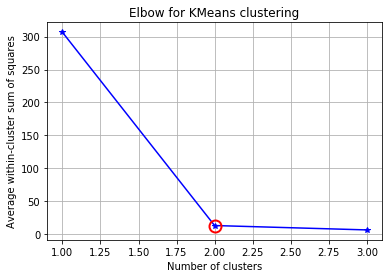

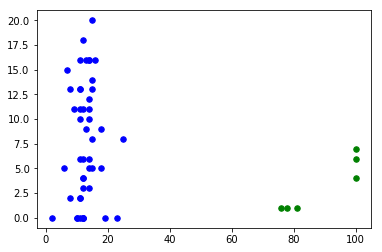

In [557]:
distance_to_centroids=[np.power(np.subtract(aSCNA.segs['TiN_MAP'][:,np.newaxis],cent),2) for cent in centroids]
cluster_assignment = [np.argmin(d,axis=1) for d in distance_to_centroids]
dist = [np.min(d,axis=1) for d in distance_to_centroids]
W_k = [sum(d)/(2*len(aSCNA.segs)) for d in dist]

X = aSCNA.segs['TiN_MAP']
Y = aSCNA.segs['Chromosome']
kIdx = 1

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k']
for i in range(K[kIdx]):
    ind = (cluster_assignment[kIdx]==i)
    ax.scatter(X[ind],Y[ind], s=30, c=clr[i], label='Cluster %d'%i)
    

In [642]:
from scipy.cluster.vq import kmeans

K = range(1, 4)
km = [kmeans(aSCNA.segs['TiN_MAP'], k) for k in K]
centroids = [cent for (cent, var) in km]
var_centroids = [var for (cent,var) in km]


In [663]:
from itertools import combinations
np.min([abs(i - j) for i,j in combinations(centroids[2], 2)])

21.666666666666671

In [624]:
N = len(aSCNA.segs['TiN_MAP'])
    cl_var = np.zeros([3,1])
    ll_cluster = np.zeros([3,1])
    for m in range(3):
        cl_var[m] =  (1.0 / (N - m)) * sum([sum(np.power(np.subtract(aSCNA.segs['TiN_MAP'][cluster_assignment[m] == i],
                                                                     centroids[m][i]), 2)) for i in range(m+1)])
        ll_cluster[m] = sum([np.sum(norm.logpdf(aSCNA.segs['TiN_MAP'][cluster_assignment[m]==i],centroids[m][i],cl_var[m])) for i in range(m+1)])


In [638]:
k = [2,6,12];
#bic = np.add(2*ll_cluster, k*np.log(N));
np.multiply(2,ll_cluster).T+np.multiply(k,np.log(N))

array([[-769.9055181 , -425.73923327, -332.80270715]])

In [622]:
cl_var[m][i]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [101]:
a = np.array(di.call_stats_table['n_alt_count'])+1
b = np.array(di.call_stats_table['n_ref_count'])+1 
rv = beta(a,b)

In [104]:
rv.mean()

array([ 0.11959654,  0.07735697,  0.08629088, ...,  0.99206349,
        0.9875    ,  0.98837209])

In [628]:
import deTiN_SSNV_based_estimate as dessnv
import deTiN_utilities as du
import scipy.integrate as integrate
dessnv=reload(dessnv)
du = reload(du)
ds = dessnv.model(du.select_candidate_mutations(di.call_stats_table),0.1)
ds.generate_conditional_ps()

In [181]:
W = np.zeros([len(ds.t_alt_count),101])
af = np.linspace(0,1,num=101)
for i,f in enumerate(af):
    if i<100:
        W[:,i] = ds.rv_normal_af.cdf(f+.01) - ds.rv_normal_af.cdf(f)
    else:
        W[:,i] = ds.rv_normal_af.pdf(f)

In [209]:
np.multiply(ds.af,ds.n_depth[:,np.newaxis])

(502, 101)

In [234]:
ds.CN_ratio.shape
ds.number_of_sites = 502

In [137]:
y=candidate_sites['tau'][:, np.newaxis]
y.shape

(502, 1)

In [211]:
n_ac_grid = np.multiply(ds.af, ds.n_depth[:, np.newaxis])

In [216]:
n_ac_given_TiN=np.multiply(ds.CN_ratio[:,9,np.newaxis],n_ac_grid)

In [230]:
beta.pdf(.01,n_ac_given_TiN[:,100]+1,ds.n_depth-n_ac_given_TiN[:,100]+1).shape

(502,)

In [235]:
bpdf_TiN = np.zeros([ds.number_of_sites, 101])

In [240]:
W.shape

(502, 101)

In [246]:
np.sum(ds.bpdf_w_tin,axis=1)

(502,)

In [275]:
ds.rv_normal_af.cdf(1)-ds.rv_normal_af.cdf(.99)

array([  1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         4.77395901e-14,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   4.77395901e-14,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,

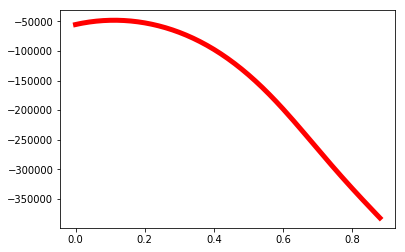

In [691]:
mode_cluster = mode(aSCNA.cluster_assignment)[0][0]
np.sum(aSCNA.TiN_likelihood[aSCNA.cluster_assignment==mode_cluster,:],axis=0)

array([ -5.41536579e+00,   1.92867293e+00,   8.50907299e+00,
         1.43361347e+01,   1.94191557e+01,   2.37664819e+01,
         2.73855532e+01,   3.02829435e+01,   3.24643967e+01,
         3.39348579e+01,   3.46985009e+01,   3.47587525e+01,
         3.41183125e+01,   3.27791720e+01,   3.07426279e+01,
         2.80092946e+01,   2.45791142e+01,   2.04513628e+01,
         1.56246558e+01,   1.00969499e+01,   3.86554339e+00,
        -3.07292555e+00,  -1.07224834e+01,  -1.90878275e+01,
        -2.81743343e+01,  -3.79880704e+01,  -4.85358054e+01,
        -5.98250270e+01,  -7.18639587e+01,  -8.46615802e+01,
        -9.82276495e+01,  -1.12572729e+02,  -1.27708213e+02,
        -1.43646361e+02,  -1.60400328e+02,  -1.77984208e+02,
        -1.96413071e+02,  -2.15703014e+02,  -2.35871205e+02,
        -2.56935941e+02,  -2.78916710e+02,  -3.01834251e+02,
        -3.25710632e+02,  -3.50569321e+02,  -3.76435279e+02,
        -4.03335045e+02,  -4.31296848e+02,  -4.60350709e+02,
        -4.90528571e+02,

In [159]:
np.log(beta.pdf(af,20+1,20+1))

array([        -inf, -62.74246557, -49.08465196, -41.18260554,
       -35.63839009, -31.38716125, -27.9546359 , -25.08784062,
       -22.63579418, -20.50113019, -18.61738589, -16.9371734 ,
       -15.42551978, -14.05588207, -12.80764342, -11.66447515,
       -10.61322854,  -9.64316332,  -8.74539689,  -7.91250287,
        -7.13821263,  -6.41718986,  -5.74485764,  -5.11726402,
        -4.53097627,  -3.98299678,  -3.47069556,  -2.99175545,
        -2.5441274 ,  -2.1259937 ,  -1.73573742,  -1.37191695,
        -1.0332447 ,  -0.71856908,  -0.42685926,  -0.15719225,
         0.09125815,   0.31923081,   0.52738533,   0.71630902,
         0.88652281,   1.0384864 ,   1.17260258,   1.28922098,
         1.38864124,   1.47111558,   1.53685106,   1.58601126,
         1.61871773,   1.63505093,   1.63505093,   1.61871773,
         1.58601126,   1.53685106,   1.47111558,   1.38864124,
         1.28922098,   1.17260258,   1.0384864 ,   0.88652281,
         0.71630902,   0.52738533,   0.31923081,   0.09

In [287]:
ds.CN_ratio.shape

(502, 101)

In [288]:
ds.psi.shape

(502,)

In [304]:
ds.TiN_range == ds.TiN

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=bool)

In [325]:
ds.expectation_of_z_given_TiN()

In [333]:
denom = np.multiply(num,np.multiply(1-ds.p_somatic,ds.)

0.046785944616828806

In [722]:
import deTiN_SSNV_based_estimate as dessnv
import deTiN_utilities as du
import scipy.integrate as integrate
dessnv=reload(dessnv)
du = reload(du)
ds = dessnv.model(du.select_candidate_mutations(di.call_stats_table),0.1)
ds.generate_conditional_ps()
ds.perform_inference()

initalized TiN to 0
TiN inference after 1 iterations = 10
TiN inference after 2 iterations = 11
TiN inference after 3 iterations = 11
SSNV based TiN estimate converged: TiN = 11


int

In [349]:
num=ds.p_somatic*ds.p_TiN_given_S[:,0]
denom = num + np.array([1-ds.p_somatic]*ds.p_TiN_given_G[:,0])

In [364]:
e_z = np.nan_to_num(np.true_divide(num,denom))

In [366]:
np.min(e_z)

0.0

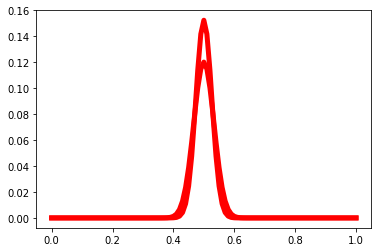

In [529]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(TiN_range, bpdf_w_tin[1,:],'r-', lw=5, label='TiN|S')
ax.plot(TiN_range, bpdf_w_tin[10,:],'r-', lw=5, label='TiN|S')


In [376]:
[ds.n_alt_count[1],ds.n_ref_count[1],ds.t_alt_count[1],ds.t_ref_count[1]]

[18, 345, 195, 201]

In [400]:
n_ac_grid_tin = np.multiply(ds.af, ds.n_depth[:, np.newaxis])
bpdf_w_tin = np.zeros([ds.number_of_sites, 101])
n_ac_given_tin = np.multiply(ds.CN_ratio[:,4,np.newaxis],n_ac_grid_tin)

In [405]:
n_ac_given_tin[1,:]

array([  0.        ,   0.13269492,   0.26538985,   0.39808477,
         0.5307797 ,   0.66347462,   0.79616955,   0.92886447,
         1.0615594 ,   1.19425432,   1.32694925,   1.45964417,
         1.5923391 ,   1.72503402,   1.85772895,   1.99042387,
         2.1231188 ,   2.25581372,   2.38850865,   2.52120357,
         2.6538985 ,   2.78659342,   2.91928834,   3.05198327,
         3.18467819,   3.31737312,   3.45006804,   3.58276297,
         3.71545789,   3.84815282,   3.98084774,   4.11354267,
         4.24623759,   4.37893252,   4.51162744,   4.64432237,
         4.77701729,   4.90971222,   5.04240714,   5.17510207,
         5.30779699,   5.44049191,   5.57318684,   5.70588176,
         5.83857669,   5.97127161,   6.10396654,   6.23666146,
         6.36935639,   6.50205131,   6.63474624,   6.76744116,
         6.90013609,   7.03283101,   7.16552594,   7.29822086,
         7.43091579,   7.56361071,   7.69630564,   7.82900056,
         7.96169549,   8.09439041,   8.22708533,   8.35

In [418]:
ds.tau[1]-0.001

1.82021840991282

In [423]:
di.call_stats_table

,contig,position,context,ref_allele,alt_allele,tumor_name,normal_name,score,dbsnp_site,covered,...,alt_count_greater3_af_greater_3percent,alt_count_greater3_af_greater_20percent,alt_count_greater10_af_greater_20percent,PoN_Germline,PoN_Artifact,bad,Chromosome,genomic_coord_x,tau,f_acs
0,1,13302,ACAxGCT,C,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.024152,0.066253,0.003767,0.070020,0.352537,1,0.0,13303,2.001000,0.500000
1,1,13418,CCCxAGA,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.324618,0.067361,0.037004,0.104365,0.482606,1,0.0,13419,2.001000,0.500000
2,1,13550,CATxGGC,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.002437,0.002881,0.000000,0.002881,0.016619,1,0.0,13551,2.001000,0.500000
3,1,13668,CCCxAAG,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.000000,0.000000,0.000000,0.003988,1,0.0,13669,2.001000,0.500000
4,1,14464,CACxGTG,A,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,UNCOVERED,...,0.000000,0.001108,0.000000,0.001108,0.037447,1,0.0,14465,2.001000,0.500000
5,1,14522,CCCxCCC,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,UNCOVERED,...,0.000000,0.004875,0.000000,0.004875,0.128518,1,0.0,14523,2.001000,0.500000
6,1,14542,TCAxGCC,A,G,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.015954,0.000000,0.015954,0.214048,1,0.0,14543,2.001000,0.500000
7,1,14574,TCCxCAC,A,G,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000222,0.029249,0.000222,0.029470,0.267228,1,0.0,14575,2.001000,0.500000
8,1,14653,CAAxGGC,C,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.013295,0.367383,0.011522,0.378905,0.346776,1,0.0,14654,2.001000,0.500000
9,1,14671,TCTxGGG,G,C,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000443,0.005761,0.000000,0.005761,0.037891,1,0.0,14672,2.001000,0.500000


In [434]:
di.call_stats_table

,contig,position,context,ref_allele,alt_allele,tumor_name,normal_name,score,dbsnp_site,covered,...,alt_count_greater2_af_greater_03percent,alt_count_greater3_af_greater_1percent,alt_count_greater3_af_greater_3percent,alt_count_greater3_af_greater_20percent,alt_count_greater10_af_greater_20percent,PoN_Germline,PoN_Artifact,bad,Chromosome,genomic_coord_x
0,1,13302,ACAxGCT,C,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.101485,0.000000,0.024152,0.066253,0.003767,0.070020,0.352537,1,0.0,13303
1,1,13418,CCCxAGA,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.087082,0.000443,0.324618,0.067361,0.037004,0.104365,0.482606,1,0.0,13419
2,1,13550,CATxGGC,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.003102,0.000000,0.002437,0.002881,0.000000,0.002881,0.016619,1,0.0,13551
3,1,13668,CCCxAAG,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003988,1,0.0,13669
4,1,14464,CACxGTG,A,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,UNCOVERED,...,0.003102,0.000000,0.000000,0.001108,0.000000,0.001108,0.037447,1,0.0,14465
5,1,14522,CCCxCCC,G,A,HCC-1143_100_T,HCC_10_90,0,NOVEL,UNCOVERED,...,0.020607,0.000000,0.000000,0.004875,0.000000,0.004875,0.128518,1,0.0,14523
6,1,14542,TCAxGCC,A,G,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.043430,0.000000,0.000000,0.015954,0.000000,0.015954,0.214048,1,0.0,14543
7,1,14574,TCCxCAC,A,G,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.060492,0.000000,0.000222,0.029249,0.000222,0.029470,0.267228,1,0.0,14575
8,1,14653,CAAxGGC,C,T,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.153113,0.000000,0.013295,0.367383,0.011522,0.378905,0.346776,1,0.0,14654
9,1,14671,TCTxGGG,G,C,HCC-1143_100_T,HCC_10_90,0,NOVEL,COVERED,...,0.004875,0.000000,0.000443,0.005761,0.000000,0.005761,0.037891,1,0.0,14672


In [449]:
np.logical_and(6512049 >= r['Start.bp'],6512049 <= r['End.bp'])

True

In [447]:
for i, r in di.seg_table.iterrows():
    if i==1:
        break

In [464]:
np.array(ds.tin_correct_tau[1] + ds.tin_correct_normal_tau[1])

array([ 1.98      ,  1.99833358,  2.01666716,  2.03500074,  2.05333432,
        2.0716679 ,  2.09000148,  2.10833506,  2.12666864,  2.14500223,
        2.16333581,  2.18166939,  2.20000297,  2.21833655,  2.23667013,
        2.25500371,  2.27333729,  2.29167087,  2.31000445,  2.32833803,
        2.34667161,  2.36500519,  2.38333877,  2.40167235,  2.42000593,
        2.43833951,  2.45667309,  2.47500668,  2.49334026,  2.51167384,
        2.53000742,  2.548341  ,  2.56667458,  2.58500816,  2.60334174,
        2.62167532,  2.6400089 ,  2.65834248,  2.67667606,  2.69500964,
        2.71334322,  2.7316768 ,  2.75001038,  2.76834396,  2.78667754,
        2.80501113,  2.82334471,  2.84167829,  2.86001187,  2.87834545,
        2.89667903,  2.91501261,  2.93334619,  2.95167977,  2.97001335,
        2.98834693,  3.00668051,  3.02501409,  3.04334767,  3.06168125,
        3.08001483,  3.09834841,  3.11668199,  3.13501558,  3.15334916,
        3.17168274,  3.19001632,  3.2083499 ,  3.22668348,  3.24

In [469]:
ds.tin_correct_normal_tau

array([ 2.  ,  1.98,  1.96,  1.94,  1.92,  1.9 ,  1.88,  1.86,  1.84,
        1.82,  1.8 ,  1.78,  1.76,  1.74,  1.72,  1.7 ,  1.68,  1.66,
        1.64,  1.62,  1.6 ,  1.58,  1.56,  1.54,  1.52,  1.5 ,  1.48,
        1.46,  1.44,  1.42,  1.4 ,  1.38,  1.36,  1.34,  1.32,  1.3 ,
        1.28,  1.26,  1.24,  1.22,  1.2 ,  1.18,  1.16,  1.14,  1.12,
        1.1 ,  1.08,  1.06,  1.04,  1.02,  1.  ,  0.98,  0.96,  0.94,
        0.92,  0.9 ,  0.88,  0.86,  0.84,  0.82,  0.8 ,  0.78,  0.76,
        0.74,  0.72,  0.7 ,  0.68,  0.66,  0.64,  0.62,  0.6 ,  0.58,
        0.56,  0.54,  0.52,  0.5 ,  0.48,  0.46,  0.44,  0.42,  0.4 ,
        0.38,  0.36,  0.34,  0.32,  0.3 ,  0.28,  0.26,  0.24,  0.22,
        0.2 ,  0.18,  0.16,  0.14,  0.12,  0.1 ,  0.08,  0.06,  0.04,
        0.02,  0.  ])

In [468]:
np.multiply((1 - ds.TiN_range), 2)

array([ 2.  ,  1.98,  1.96,  1.94,  1.92,  1.9 ,  1.88,  1.86,  1.84,
        1.82,  1.8 ,  1.78,  1.76,  1.74,  1.72,  1.7 ,  1.68,  1.66,
        1.64,  1.62,  1.6 ,  1.58,  1.56,  1.54,  1.52,  1.5 ,  1.48,
        1.46,  1.44,  1.42,  1.4 ,  1.38,  1.36,  1.34,  1.32,  1.3 ,
        1.28,  1.26,  1.24,  1.22,  1.2 ,  1.18,  1.16,  1.14,  1.12,
        1.1 ,  1.08,  1.06,  1.04,  1.02,  1.  ,  0.98,  0.96,  0.94,
        0.92,  0.9 ,  0.88,  0.86,  0.84,  0.82,  0.8 ,  0.78,  0.76,
        0.74,  0.72,  0.7 ,  0.68,  0.66,  0.64,  0.62,  0.6 ,  0.58,
        0.56,  0.54,  0.52,  0.5 ,  0.48,  0.46,  0.44,  0.42,  0.4 ,
        0.38,  0.36,  0.34,  0.32,  0.3 ,  0.28,  0.26,  0.24,  0.22,
        0.2 ,  0.18,  0.16,  0.14,  0.12,  0.1 ,  0.08,  0.06,  0.04,
        0.02,  0.  ])

In [474]:
x=ds.tin_correct_tau + ds.tin_correct_normal_tau

In [476]:
x[1,29]

1.9516738363419321

In [480]:
ds.CN_ratio[1,29]

0.27241941068311948

In [569]:
ds.E_z[1]

array([ 1.])

In [483]:
ds.t_af_w[1,:]

array([  1.67769157e-275,   2.21307618e-217,   9.29703954e-184,
         3.60308024e-160,   4.38593500e-142,   1.75028521e-127,
         2.73212614e-115,   7.32551659e-105,   8.76058350e-096,
         8.96332718e-088,   1.24838268e-080,   3.33450493e-074,
         2.21567117e-068,   4.48263923e-063,   3.24064156e-058,
         9.52307779e-054,   1.26387177e-049,   8.26478239e-046,
         2.86409754e-042,   5.59331077e-039,   6.48638412e-036,
         4.67179406e-033,   2.17243021e-030,   6.74546871e-028,
         1.44030011e-025,   2.17007098e-023,   2.36020046e-021,
         1.89064890e-019,   1.13555753e-017,   5.19564282e-016,
         1.83675849e-014,   5.08094464e-013,   1.11233784e-011,
         1.94687174e-010,   2.74915136e-009,   3.15765004e-008,
         2.97172254e-007,   2.30660165e-006,   1.48523195e-005,
         7.97503061e-005,   3.58748174e-004,   1.35747539e-003,
         4.33614516e-003,   1.17285068e-002,   2.69333706e-002,
         5.26264503e-002,   8.76519412e-

In [485]:
n_ac_grid_tin = np.multiply(ds.af, ds.n_depth[:, np.newaxis])
n_ac_grid_tin[1,:]

array([   0.  ,    3.63,    7.26,   10.89,   14.52,   18.15,   21.78,
         25.41,   29.04,   32.67,   36.3 ,   39.93,   43.56,   47.19,
         50.82,   54.45,   58.08,   61.71,   65.34,   68.97,   72.6 ,
         76.23,   79.86,   83.49,   87.12,   90.75,   94.38,   98.01,
        101.64,  105.27,  108.9 ,  112.53,  116.16,  119.79,  123.42,
        127.05,  130.68,  134.31,  137.94,  141.57,  145.2 ,  148.83,
        152.46,  156.09,  159.72,  163.35,  166.98,  170.61,  174.24,
        177.87,  181.5 ,  185.13,  188.76,  192.39,  196.02,  199.65,
        203.28,  206.91,  210.54,  214.17,  217.8 ,  221.43,  225.06,
        228.69,  232.32,  235.95,  239.58,  243.21,  246.84,  250.47,
        254.1 ,  257.73,  261.36,  264.99,  268.62,  272.25,  275.88,
        279.51,  283.14,  286.77,  290.4 ,  294.03,  297.66,  301.29,
        304.92,  308.55,  312.18,  315.81,  319.44,  323.07,  326.7 ,
        330.33,  333.96,  337.59,  341.22,  344.85,  348.48,  352.11,
        355.74,  359

In [487]:
n_ac_grid_tin[1,:]*ds.CN_ratio[1,:]

array([  0.00000000e+00,   3.33031973e-02,   1.33323969e-01,
         3.00229501e-01,   5.34187541e-01,   8.35366395e-01,
         1.20393494e+00,   1.64006260e+00,   2.14391939e+00,
         2.71567589e+00,   3.35550325e+00,   4.06357319e+00,
         4.84005802e+00,   5.68513061e+00,   6.59896445e+00,
         7.58173357e+00,   8.63361263e+00,   9.75477685e+00,
         1.09454021e+01,   1.22056647e+01,   1.35357417e+01,
         1.49358108e+01,   1.64060502e+01,   1.79466386e+01,
         1.95577556e+01,   2.12395811e+01,   2.29922958e+01,
         2.48160811e+01,   2.67111188e+01,   2.86775914e+01,
         3.07156820e+01,   3.28255744e+01,   3.50074531e+01,
         3.72615030e+01,   3.95879098e+01,   4.19868598e+01,
         4.44585399e+01,   4.70031377e+01,   4.96208415e+01,
         5.23118401e+01,   5.50763231e+01,   5.79144805e+01,
         6.08265034e+01,   6.38125831e+01,   6.68729118e+01,
         7.00076823e+01,   7.32170882e+01,   7.65013236e+01,
         7.98605833e+01,

In [621]:
bpdf_w_tin = np.zeros([ds.number_of_sites,101])
ds.normal_f = np.true_divide(ds.n_alt_count,ds.n_depth)
ds.TiN_range = np.linspace(0, 1, num=101)
n_af_w = np.zeros([ds.number_of_sites, 101])
t_af_w = np.zeros([ds.number_of_sites, 101])
for i,f in enumerate(ds.af):
    n_af_w[:, i] = ds.rv_normal_af.cdf(f + .01) - ds.rv_normal_af.cdf(f)
    t_af_w[:,i] = ds.rv_tumor_af.cdf(f+ .01) - ds.rv_tumor_af.cdf(f)
    
    t_af=np.multiply(f,ds.n_depth)
    n_ac_given_tin = np.multiply(t_af[:,np.newaxis],ds.CN_ratio)
    
    psi_t_af = .5-np.abs((.5-f))
    exp_f = 0.5 + np.multiply(psi_t_af , ds.CN_ratio)
    for TiN_idx,TiN in enumerate(ds.TiN_range):
        bpdf_w_tin[:,TiN_idx] += np.multiply(beta.pdf(ds.normal_f[:],n_ac_given_tin[:,TiN_idx]+1,
                                            ds.n_depth[:]-n_ac_given_tin[:,TiN_idx]+1)*0.01,t_af_w[:,i])

        

NameError: name 'self' is not defined

In [635]:
dir_psi = ds.psi * ds.t_het_direction
exp_f = 0.5 + np.multiply(dir_psi[:,np.newaxis] , ds.CN_ratio)


In [678]:
t_het_direction = np.ones([ds.number_of_sites,101])
i=100
f=1
t_het_direction[:,0:50] = -1
f_t_af = .5-np.abs((.5-f))
psi_t_af = .5 - f_t_af
psi_t_af = np.multiply(psi_t_af,t_het_direction[:,i])
exp_f = 0.5 + np.multiply(psi_t_af[:,np.newaxis],ds.CN_ratio)
n_het_ac_given_tin = np.multiply(exp_f,ds.n_depth[:,np.newaxis])
n_het_ac_given_tin[32,:]

array([ 20.        ,  20.16621574,  20.33299967,  20.50035471,
        20.6682838 ,  20.83678988,  21.00587596,  21.17554501,
        21.34580007,  21.51664418,  21.68808039,  21.86011179,
        22.03274149,  22.20597261,  22.3798083 ,  22.55425173,
        22.72930609,  22.90497461,  23.08126051,  23.25816705,
        23.43569753,  23.61385524,  23.79264352,  23.97206572,
        24.15212521,  24.33282541,  24.51416973,  24.69616163,
        24.87880457,  25.06210207,  25.24605764,  25.43067484,
        25.61595724,  25.80190844,  25.98853207,  26.17583179,
        26.36381127,  26.55247422,  26.74182439,  26.93186552,
        27.1226014 ,  27.31403586,  27.50617275,  27.69901592,
        27.89256929,  28.08683678,  28.28182235,  28.47753   ,
        28.67396374,  28.87112762,  29.06902572,  29.26766215,
        29.46704104,  29.66716656,  29.86804293,  30.06967437,
        30.27206515,  30.47521956,  30.67914194,  30.88383665,
        31.08930808,  31.29556066,  31.50259886,  31.71

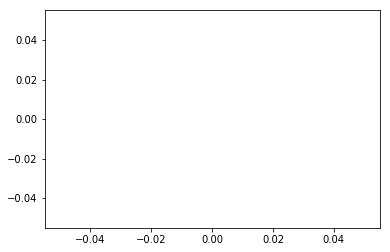

In [696]:
site=1
x=np.multiply(beta.pdf(ds.af,n_ac_given_tin[site,TiN_idx]+1,
                                                  ds.n_depth[site]-n_ac_given_tin[site,TiN_idx]+1),0.01)
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
ds.tumor_f = np.true_divide(ds.t_alt_count,ds.t_depth)
fig, ax = plt.subplots(1, 1)
w_sites = ds.E_z>.5
w_index = list(compress(xrange(len(w_sites)), w_sites))
ax.plot(np.sum(np.log(ds.p_TiN_given_S),axis=0),'b.', lw=5, label='TiN|S')



In [613]:
w_sites = ds.genomic_coord_x == 161954797
w_index = list(compress(xrange(len(w_sites)), w_sites))
w_index

[32]

In [705]:

np.nansum(np.multiply(ds.E_z,np.log(ds.p_TiN_given_S)),axis=0)

array([ -1675.93609532,  -2326.65971525,  -2088.13955938,  -1906.84778079,
        -1766.51895879,  -1658.05575267,  -1575.54680852,  -1514.80503195,
        -1472.69278621,  -1446.76391772,  -1435.0548426 ,  -1435.95375018,
        -1448.11415432,  -1470.39523431,  -1501.81918438,  -1541.53981267,
        -1588.81883965,  -1643.00762243,  -1703.5327999 ,  -1769.88483362,
        -1841.60872816,  -1918.29641821,  -1999.58044773,  -2085.12866118,
        -2174.63969359,  -2267.83909429,  -2364.47595399,  -2464.31993217,
        -2567.15860375,  -2672.79506462,  -2781.04575578,  -2891.73848779,
        -3004.71066647,  -3119.80773207,  -3236.88181609,  -3355.79058952,
        -3476.3962361 ,  -3598.56445803,  -3722.16341221,  -3847.06243728,
        -3973.13036114,  -4100.23327914,  -4228.23229564,  -4356.98269419,
        -4486.33615826,  -4616.14565189,  -4746.26976416,  -4876.57394235,
        -5006.93002588,  -5137.21657472,  -5267.31912276,  -5397.12782533,
        -5526.53292624,  

In [580]:
x=np.array(ds.E_z>.5)
x.shape

(502, 1)

AttributeError: 'float' object has no attribute 'type'